In [1]:
import os
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import shutil
import pandas as pd
from source import image_id_converter as img_idc
from source import sort_img_files as sif
from source import detect_persons_yolo as dpy
from source import llm_input as llm_i
from source import llm_output as llm_o
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import ollama
import json
import re
import pickle

In [3]:
os.getcwd()

'/storage/homefs/sh98e089'

In [4]:
# !rm yolov8n.pt

In [5]:
def store_duration(time_analysis_dict, time_analysis_for_df_dict, analysis_name, duration,
                  timestamp_start_is_photo_analysis,
                  timestamp_end_is_photo_analysis):
    time_analysis_dict[analysis_name] = {}
    time_analysis_dict[analysis_name]['duration_str'] = f"Analysis took: {duration}"
    time_analysis_dict[analysis_name]['duration_seconds'] = total_seconds
    time_analysis_dict[analysis_name]['duration_seconds_str'] = f"Analysis took: {total_seconds:.2f} seconds"
    time_analysis_dict[analysis_name]['duration_minutes'] = total_seconds/60
    time_analysis_dict[analysis_name]['duration_minutes_str'] = f"Analysis took: {total_seconds/60:.2f} minutes"
    time_analysis_dict[analysis_name]['time_stamp_start'] = timestamp_start_is_photo_analysis
    time_analysis_dict[analysis_name]['time_stamp_end'] = timestamp_end_is_photo_analysis

    time_analysis_for_df_dict['analysis_name'].append(analysis_name)
    time_analysis_for_df_dict['time_stamp_start'].append(timestamp_start_is_photo_analysis)
    time_analysis_for_df_dict['duration_str'].append(f"Analysis took: {duration}")
    time_analysis_for_df_dict['duration_seconds'].append(total_seconds)
    time_analysis_for_df_dict['duration_seconds_str'].append(f"Analysis took: {total_seconds:.2f} seconds")
    time_analysis_for_df_dict['duration_minutes'].append(total_seconds/60)
    time_analysis_for_df_dict['duration_minutes_str'].append(f"Analysis took: {total_seconds/60:.2f} minutes")

    return time_analysis_dict, time_analysis_for_df_dict
    

### Prepare empty dictionary for time analyses and get time stamp for overall workflow duration:

In [6]:
time_analyses = {}
time_analyses_for_df = {}
time_analyses_for_df['analysis_name'] = []
time_analyses_for_df['time_stamp_start'] = []
time_analyses_for_df['duration_str'] = []
time_analyses_for_df['duration_seconds'] = []
time_analyses_for_df['duration_seconds_str'] = []
time_analyses_for_df['duration_minutes'] = []
time_analyses_for_df['duration_minutes_str'] = []

timestamp_start_workflow = pd.Timestamp.now()
timestamp_start_workflow

Timestamp('2025-11-25 17:09:53.192432')

### Prepare empty data frame to store performance metrics:

In [7]:
ml_metrics = pd.DataFrame({})

## Set paths:

In [8]:
#root_path = Path('/Users/stephanehess/Documents/CAS_AML/dias_digit_project/project')

In [9]:
project_path = Path(os.getcwd())
root_path = project_path / 'test_filter_out_people_multi_approach'
# root_path = project_path


In [10]:

# Define paths
# image_dir = root_path/"../data"  # Replace with your directory containing images
# Adaptation to the different file structure on ubelix: 
data_path = root_path/"data"  # Replace with your directory containing images
tif_data_path = root_path / 'data_1'
jpg_data_path = root_path / 'data_jpg'
image_dir = jpg_data_path


### Load label data:

In [11]:
label_data = pd.read_csv(data_path/'labels_mod.csv')
label_data.head()

,image_id,with_person,person_recognisable,is_photo,with_church,in_high_alpine_environment
0,id001,1,1,1,0,0
1,id002,0,0,1,1,0
2,id003,0,0,1,0,0
3,id004,0,0,1,0,0
4,id005,0,0,1,0,0


In [12]:
# Reconvert image ids to integers (e.g. '234') as strings from the form they were saved in (e.g. 'id234' 
# to ensure string data type to deal with duck typing): 
img_ids = list(label_data.image_id)
label_data['image_id'] = img_idc.reconvert_image_ids(img_ids)
label_data.head()

,image_id,with_person,person_recognisable,is_photo,with_church,in_high_alpine_environment
0,001,1,1,1,0,0
1,002,0,0,1,1,0
2,003,0,0,1,0,0
3,004,0,0,1,0,0
4,005,0,0,1,0,0


### The following cell is only required for the test run on the test data: 

In [13]:
# Select only rows referring to images in the smaller data set (test run):

# Make sure no .DS_Store file is included in jpg_data_path: 
import os
ds_file_path = jpg_data_path / '.DS_Store'

# Remove a specific .DS_Store file
if os.path.exists(ds_file_path):
    os.remove(ds_file_path)
    print("Removed .DS_Store")
else:
    print(".DS_Store not found")

# Find all .ipynb_checkpoints directories
for checkpoint_dir in jpg_data_path.rglob('.ipynb_checkpoints'):
    if checkpoint_dir.is_dir():
        print(f"Removing: {checkpoint_dir}")
        shutil.rmtree(checkpoint_dir)



# Get list of image files present:
image_files = os.listdir(jpg_data_path)

#image_files.remove(".ipynb_checkpoints")



# Extract image ids from image file names:
img_ids = [image_file.split('Oberland')[1].split('.')[0] for image_file in image_files]
img_ids.sort()
print(img_ids)

# Select relevant rows from label_data data frame by id list: 
select_bools = [img_id in img_ids for img_id in label_data.image_id]

label_data = label_data[select_bools].copy()
label_data

.DS_Store not found
['002', '003', '008', '015', '022', '023', '033', '035', '043', '081', '082', '107']


,image_id,with_person,person_recognisable,is_photo,with_church,in_high_alpine_environment
1,002,0,0,1,1,0
2,003,0,0,1,0,0
7,008,0,0,1,1,0
14,015,1,1,1,0,0
21,022,0,0,0,0,0
22,023,1,1,1,0,0
32,033,0,0,0,0,0
34,035,0,0,1,1,0
42,043,0,0,1,1,0
80,081,0,0,0,0,0


In [14]:
source_folder = tif_data_path
destination_folder = jpg_data_path

llm_i.convert_tif_to_jpg(source_folder, destination_folder, quality=100)


Error converting BernerOberland002.tif: cannot identify image file '/storage/homefs/sh98e089/test_filter_out_people_multi_approach/data_1/BernerOberland002.tif'
Error converting BernerOberland023.tif: cannot identify image file '/storage/homefs/sh98e089/test_filter_out_people_multi_approach/data_1/BernerOberland023.tif'
Converted: BernerOberland081.tif -> BernerOberland081.jpg
Converted: BernerOberland033.tif -> BernerOberland033.jpg
Converted: BernerOberland043.tif -> BernerOberland043.jpg
Error converting BernerOberland008.tif: cannot identify image file '/storage/homefs/sh98e089/test_filter_out_people_multi_approach/data_1/BernerOberland008.tif'
Error converting BernerOberland107.tif: cannot identify image file '/storage/homefs/sh98e089/test_filter_out_people_multi_approach/data_1/BernerOberland107.tif'
Converted: BernerOberland082.tif -> BernerOberland082.jpg
Error converting BernerOberland035.tif: cannot identify image file '/storage/homefs/sh98e089/test_filter_out_people_multi_ap

['BernerOberland081.jpg',
 'BernerOberland033.jpg',
 'BernerOberland043.jpg',
 'BernerOberland082.jpg',
 'BernerOberland015.jpg',
 'BernerOberland022.jpg']

## Yolo:

## Define the pretrained model:

In [15]:
# Load the YOLOv5 model
model = YOLO("yolov8n.pt")  # Use yolov8n (nano) for faster inference


## Detect persons with pretrained yolo:

In [16]:
analysis_name = 'pers_yolo'
label_name = 'with_person'
prediction_name = 'with_person_yolo_pred'

In [17]:
# img_ids, with_person = sif.sort_img_files(image_dir, model, output_dir_with_person, 
#                                           output_dir_without_person, threshold=0.25)


timestamp_start_pers_yolo = pd.Timestamp.now()

img_ids, with_person = dpy.detect_persons_yolo(image_dir, model, threshold=0.25,
                                              file_format="jpg")
timestamp_end_pers_yolo = pd.Timestamp.now()


duration = timestamp_end_pers_yolo - timestamp_start_pers_yolo

total_seconds = duration.total_seconds()
print(total_seconds)

# Store information about duration: 
time_analyses, time_analyses_for_df = store_duration(time_analyses, time_analyses_for_df, analysis_name, 
               duration, timestamp_start_pers_yolo,
              timestamp_end_pers_yolo)


Filtering complete!
5.407619


In [18]:
print(img_ids)

['008', '015', '081', '035', '033', '003', '043', '022', '082', '107', '023', '002']


In [19]:
print(with_person)

[False, True, False, True, False, False, False, False, False, False, True, True]


In [20]:
print(len(img_ids))
print(len(with_person))

12
12


## Load person predictions into a dataframe: 

In [21]:
results_person = pd.DataFrame({'image_id': img_ids, label_name: with_person})
results_person.head()


,image_id,with_person
0,008,False
1,015,True
2,081,False
3,035,True
4,033,False


## Add one-hot-coded person predictions:

In [22]:
results_person['with_person_yolo_pred']= [1 if x else 0 for x in results_person.with_person]
results_person_select = results_person.loc[:, ['image_id', prediction_name]]
results_person_select.head()

,image_id,with_person_yolo_pred
0,008,0
1,015,1
2,081,0
3,035,1
4,033,0


In [23]:
with_without_person = pd.read_csv(data_path/'labels_mod.csv')
with_without_person

,image_id,with_person,person_recognisable,is_photo,with_church,in_high_alpine_environment
0,id001,1,1,1,0,0
1,id002,0,0,1,1,0
2,id003,0,0,1,0,0
3,id004,0,0,1,0,0
4,id005,0,0,1,0,0
...,...,...,...,...,...,...
106,id107,0,0,1,0,0
107,id108,1,0,1,0,0
108,id109,0,0,1,0,1
109,id110,0,0,1,0,0


### Get relevant part of label data: 

In [24]:
### Take copy of label_data and select relevant columns:
with_without_person = label_data.copy()
with_without_person = with_without_person.iloc[:, 0:3]
with_without_person.head()

,image_id,with_person,person_recognisable
1,002,0,0
2,003,0,0
7,008,0,0
14,015,1,1
21,022,0,0


## Merge label data with the predictions:

In [25]:
labels_results = with_without_person.merge(results_person_select, how='inner', on='image_id')
labels_results.head()

,image_id,with_person,person_recognisable,with_person_yolo_pred
0,002,0,0,1
1,003,0,0,0
2,008,0,0,0
3,015,1,1,1
4,022,0,0,0


In [26]:
labels_results

,image_id,with_person,person_recognisable,with_person_yolo_pred
0,002,0,0,1
1,003,0,0,0
2,008,0,0,0
3,015,1,1,1
4,022,0,0,0
5,023,1,1,1
6,033,0,0,0
7,035,0,0,1
8,043,0,0,0
9,081,0,0,0


## Calculate sensitivity and specificity for person predictions and get the different data subsets based on label and predictions:

In [27]:
subsets_and_metrics = llm_o.get_classification_subsets_metrics(labels_results, label_name, 
                                                               'with_person_yolo_pred')


In [28]:
positives, negatives, true_positives, true_negatives, false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics 
print(sensitivity)
print(specificity)

1.0
0.8


## Inspect false negatives:

In [29]:
false_negatives

,image_id,with_person,person_recognisable,with_person_yolo_pred


## Inspect false positives:

In [30]:
false_positives

,image_id,with_person,person_recognisable,with_person_yolo_pred
0,002,0,0,1
7,035,0,0,1


In [31]:
number_positives = positives.shape[0]
number_negatives = negatives.shape[0]
number_true_positives = true_positives.shape[0]
number_false_positives = false_positives.shape[0]
number_true_negatives = true_negatives.shape[0]
number_false_negatives = false_negatives.shape[0]

### Add performance metrics to data frame: 

In [32]:
ml_metrics_to_stack = pd.DataFrame({})
ml_metrics_to_stack['analysis_name'] = [analysis_name]
ml_metrics_to_stack['time_stamp'] = [timestamp_start_pers_yolo]
ml_metrics_to_stack['positives'] = [number_positives]
ml_metrics_to_stack['negatives'] = [number_negatives]
ml_metrics_to_stack['true_positives'] = [number_true_positives]
ml_metrics_to_stack['false_positives'] = [number_false_positives]
ml_metrics_to_stack['true_negatives'] = [number_true_negatives]
ml_metrics_to_stack['false_negatives'] = [number_false_negatives]
ml_metrics_to_stack['sensitivity'] = [sensitivity]
ml_metrics_to_stack['specificity'] = [specificity]

ml_metrics_to_concat = [ml_metrics, ml_metrics_to_stack]
ml_metrics = pd.concat(ml_metrics_to_concat)
ml_metrics

,analysis_name,time_stamp,positives,negatives,true_positives,false_positives,true_negatives,false_negatives,sensitivity,specificity
0,pers_yolo,2025-11-25 17:09:57.343999,2,10,2,2,8,0,1.0,0.8


### Plot confusion matrix:

Confusion Matrix:


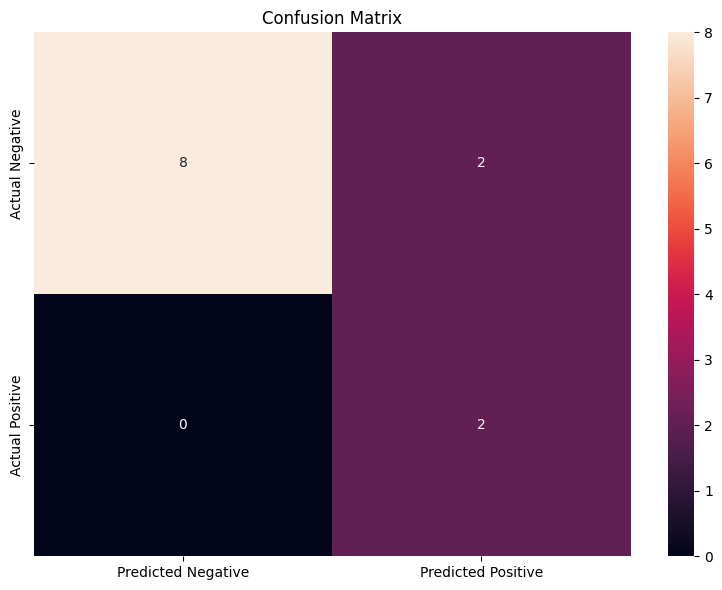

True Positives: 2
False Positives: 2
True Negatives: 8
False Negatives: 0

Sensitivity (Recall): 1.0000
Specificity: 0.8000
Precision: 0.5000
Miss Rate (False Negative Rate): 0.0000
F1 Score: 0.6667


In [33]:

cases = true_positives, false_positives, true_negatives, false_negatives, positives, negatives

# llm_o.plot_conf_matrix(labels_results, 'with_person', 'with_person_yolo_pred', cases)
fig = llm_o.save_conf_matrix(labels_results, label_name, 'with_person_yolo_pred', cases)


### Save confusion matrix as pdf:

In [34]:
# The fig object was created when plotting the confusion matrix
# so now we can use it to save the plot as pdf:
file_name = 'conf_matrix_metrics_' + analysis_name + '.pdf'
conf_matrix_path = data_path / file_name
fig.savefig(conf_matrix_path)
plt.close(fig)


## Recalculate Measures with recognisable_label as ground truth (instead of person_label):

In [35]:
analysis_name = 'pers_recognisable_yolo'
label_name = 'person_recognisable'
prediction_name = 'with_person_yolo_pred'

## Calculate sensitivity and specificity for person predictions and get the different data subsets based on label and predictions:

In [36]:
subsets_and_metrics = llm_o.get_classification_subsets_metrics(labels_results, label_name, 
                                                               prediction_name)

In [37]:
(positives, negatives, true_positives, true_negatives, false_negatives, 
 false_positives, sensitivity, specificity) = subsets_and_metrics
print(sensitivity) 
print(specificity)

1.0
0.8


In [38]:
number_positives = positives.shape[0]
number_negatives = negatives.shape[0]
number_true_positives = true_positives.shape[0]
number_false_positives = false_positives.shape[0]
number_true_negatives = true_negatives.shape[0]
number_false_negatives = false_negatives.shape[0]

### Add performance metrics to data frame: 

In [39]:
ml_metrics_to_stack = pd.DataFrame({})
ml_metrics_to_stack['analysis_name'] = [analysis_name]
ml_metrics_to_stack['time_stamp'] = [timestamp_start_pers_yolo]
ml_metrics_to_stack['positives'] = [number_positives]
ml_metrics_to_stack['negatives'] = [number_negatives]
ml_metrics_to_stack['true_positives'] = [number_true_positives]
ml_metrics_to_stack['false_positives'] = [number_false_positives]
ml_metrics_to_stack['true_negatives'] = [number_true_negatives]
ml_metrics_to_stack['false_negatives'] = [number_false_negatives]
ml_metrics_to_stack['sensitivity'] = [sensitivity]
ml_metrics_to_stack['specificity'] = [specificity]

ml_metrics_to_concat = [ml_metrics, ml_metrics_to_stack]
ml_metrics = pd.concat(ml_metrics_to_concat)
ml_metrics

,analysis_name,time_stamp,positives,negatives,true_positives,false_positives,true_negatives,false_negatives,sensitivity,specificity
0,pers_yolo,2025-11-25 17:09:57.343999,2,10,2,2,8,0,1.0,0.8
0,pers_recognisable_yolo,2025-11-25 17:09:57.343999,2,10,2,2,8,0,1.0,0.8


### Plot confusion matrix:

Confusion Matrix:


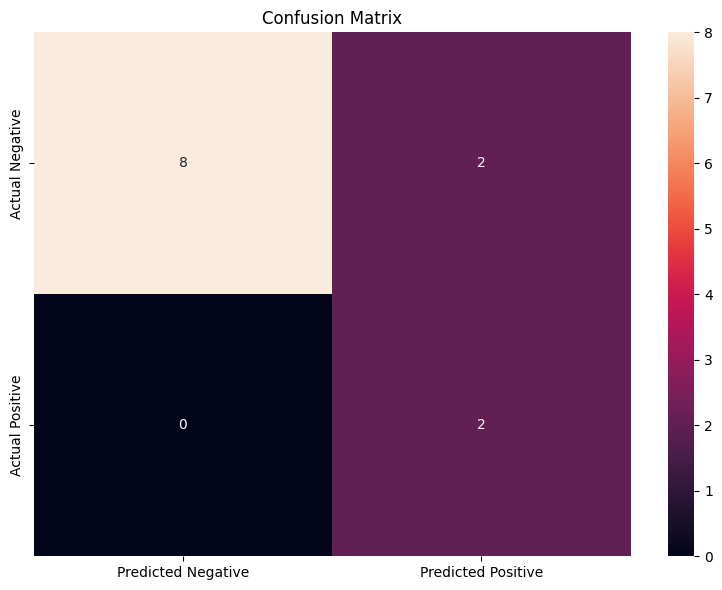

True Positives: 2
False Positives: 2
True Negatives: 8
False Negatives: 0

Sensitivity (Recall): 1.0000
Specificity: 0.8000
Precision: 0.5000
Miss Rate (False Negative Rate): 0.0000
F1 Score: 0.6667


In [40]:
cases = true_positives, false_positives, true_negatives, false_negatives, positives, negatives

#llm_o.plot_conf_matrix(labels_results, 'person_recognisable', 'with_person_yolo_pred', cases)
fig = llm_o.save_conf_matrix(labels_results, label_name, prediction_name, cases)


### Save confusion matrix as pdf:

In [41]:

# The fig object was created when plotting the confusion matrix
# so now we can use it to save the plot as pdf:
file_name = 'conf_matrix_metrics_' + analysis_name + '.pdf'
conf_matrix_path = data_path / file_name
fig.savefig(conf_matrix_path)
plt.close(fig)


In [42]:
labels_results

,image_id,with_person,person_recognisable,with_person_yolo_pred
0,002,0,0,1
1,003,0,0,0
2,008,0,0,0
3,015,1,1,1
4,022,0,0,0
5,023,1,1,1
6,033,0,0,0
7,035,0,0,1
8,043,0,0,0
9,081,0,0,0


## LLM

In [ ]:
def create_analysis_prompt_person():
    """Create the structured prompt for image analysis."""
    return """
    Analyze this image and return ONLY a Python dictionary in exactly this format:
    
    {
        'contains_persons': X,  # True if the image contains a person or multiple persons, False if the image does not contain any person.
        'additional_comments': '' # Any additional observations or empty string if none.
    }
    
    Replace X with True (image contains one or multiple persons) or False (does not contain any person).
    Return ONLY the dictionary, no other text.
    Your answer MUST have the exact structue of the dictionary described above (all keys MUST be present). 
    If you cannot answer the question in the way implied by this structure, enter 'None' as value and offer 
    your answer and explanations under 'additional_comments'.
    """

In [ ]:
def analyse_giub_img_dir_llm(jpg_data_path, create_analysis_prompt, model_function):
    # Get time stamp:
    timestamp_start_is_photo_analysis = pd.Timestamp.now()
    
    # Get list of image files to analyse: 
    image_files = os.listdir(jpg_data_path)
    print(image_files)
    img_ids = [image_file.split('Oberland')[1].split('.')[0] for image_file in image_files]
    
    # Make empty dictionary to store results:
    image_descr = {}
    
    # Loop through images to get answers: 
    for image_file in image_files:
        image_path = jpg_data_path / image_file
        path_str = str(image_path)
        print('\n')
        print(path_str)
        parts = path_str.split('.jpg')
        img_id = parts[-2][-3:]
    
        # Analyse image, get values for each of the categorical variables specified above:
        #image_description = analyze_image_structured(image_path)
        #image_description = llm_o.analyze_image_structured(image_path, create_analysis_prompt)
        image_description = llm_o.analyze_image_structured(image_path, create_analysis_prompt, model_function)
        print(image_description)
        
        dict_type_bool = type(image_description) == dict
            
        #print(image_description)
        image_descr[img_id] = image_description
    
    timestamp_end_is_photo_analysis = pd.Timestamp.now()

    return timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr

### Choose LLM Model

In [ ]:
model_function = llm_i.call_minicpm_model

### Prepare empty dictionary to store the different response dictionaries:

In [ ]:
response_dictionaries = {}


### Prepare empty dictionary for cases with unstructured answers for visual inspection:

In [ ]:
images_closer_inspection = {}


### Prepare empty dictionary for result dataframes:

In [ ]:
results_tabular = {}

## Identify non-photo images with intuitive prompt:

### Set parameters:

In [ ]:
# Set parameters: 
analysis_name = 'pers_struct_minicpm'
create_analysis_prompt = create_analysis_prompt_person
keys_list_expected = ['contains_persons', 'additional_comments']
response_variable = 'contains_persons'

label_name = 'with_person'
prediction_name = 'with_person_minicpm_pred'

### Prepare data objects: 

In [ ]:
# Prepare data objects: 
labels_results_repetitions = []
response_dictionaries[analysis_name] = {}

ml_metrics_analysis_name = []
ml_metrics_time_stamp = []
ml_metrics_positives = []
ml_metrics_negatives = []
ml_metrics_true_positives = []
ml_metrics_false_positives = []
ml_metrics_true_negatives = []
ml_metrics_false_negatives = []
ml_metrics_sensitivity = []
ml_metrics_specificity = []

### Extract and store results:

In [ ]:
itercount = 0

while itercount < 1:

    # Analysis with LLM: 
    timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr = analyse_giub_img_dir_llm(jpg_data_path, create_analysis_prompt, model_function)

    # Calculate duration of analysis: 
    duration = timestamp_end_is_photo_analysis - timestamp_start_is_photo_analysis
    total_seconds = duration.total_seconds()
    print(total_seconds)

    # Store information about duration: 
    time_analyses, time_analyses_for_df = store_duration(time_analyses, time_analyses_for_df, analysis_name, 
                   duration,timestamp_start_is_photo_analysis,
                  timestamp_end_is_photo_analysis)
    
    # Store dictionary with LLM responses:
    response_dictionaries[analysis_name][timestamp_start_is_photo_analysis] = image_descr
    
    # Extract LLM responses from dictionary:
    img_ids, is_photo, img_ids_closer_inspection = \
    llm_o.extract_vals_from_response_dict(img_ids, image_descr, keys_list_expected, response_variable)
    
    # Check if the response variable lists has the same length as id list:
    # print('Length of img_ids:')
    # print(len(img_ids))
    # print('Length of is_photo:')
    # print(len(is_photo))
    
    # Put response variables into data frame: 
    # timestamp_ids = [timestamp_start_is_photo_analysis] * len(img_ids)
    # predictions = pd.DataFrame({'image_id': img_ids, 
    #                            prediction_name: is_photo,
    #                           'time_stamp': timestamp_ids})

    timestamp_ids = [timestamp_start_is_photo_analysis] * len(img_ids)
    predictions = pd.DataFrame({'image_id': img_ids, 
                               prediction_name: is_photo})
    
    # Check for missing values:
    # print(predictions.isnull().any().any())
    # print(predictions.isna().any().any())
    # print(has_missing_comprehensive(predictions))
    
    # Merge label data with the predictions:
    labels_results_c = labels_results.copy()
    labels_results_i = labels_results_c.merge(predictions, how='inner', on='image_id')
    print(labels_results_i.shape)
    labels_results_repetitions.append(labels_results_i)
    
    # Save labels and predictions in dictionary: 
    #results_tabular[analysis_name] = {}
    #results_tabular[analysis_name][timestamp_start_is_photo_analysis] = labels_results
    
    # Save image list for closer inspection:
    timestamp_ids = [timestamp_start_is_photo_analysis] * len(img_ids_closer_inspection)
    imgs_closer_inspection = pd.DataFrame({'image_id': img_ids_closer_inspection,
    'time_stamp': timestamp_ids})
    images_closer_inspection[analysis_name] = imgs_closer_inspection
    
    
    # Calculate sensitivity and specificity for photography predictions and get lists images with positive photography predictions:
    subsets_and_metrics = llm_o.get_classification_subsets_metrics(labels_results_i, label_name, prediction_name)
    positives, negatives, true_positives, true_negatives, \
    false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics
    # ml_metrics['analysis_name'] = analysis_name
    # ml_metrics['time_stamp'] = timestamp_start_is_photo_analysis
    # ml_metrics['positives'] = positives.shape[0]
    # ml_metrics['negatives'] = negatives.shape[0]
    # ml_metrics['true_positives'] = true_positives.shape[0]
    # ml_metrics['false_positives'] = false_positives.shape[0]
    # ml_metrics['true_negatives'] = true_negatives.shape[0]
    # ml_metrics['false_negatives'] = false_negatives.shape[0]
    # ml_metrics['sensitivity'] = sensitivity
    # ml_metrics['specificity'] = specificity


    ml_metrics_analysis_name.append(analysis_name)
    ml_metrics_time_stamp.append(timestamp_start_is_photo_analysis)
    ml_metrics_positives.append(positives.shape[0])
    ml_metrics_negatives.append(negatives.shape[0])
    ml_metrics_true_positives.append(true_positives.shape[0])
    ml_metrics_false_positives.append(false_positives.shape[0])
    ml_metrics_true_negatives.append(true_negatives.shape[0])
    ml_metrics_false_negatives.append(false_negatives.shape[0])
    ml_metrics_sensitivity.append(sensitivity)
    ml_metrics_specificity.append(specificity)
    
    
    
    print(f'True Positives: {true_positives.shape[0]}')
    print(f'False Positives: {false_positives.shape[0]}')
    print(f'True Negatives: {true_negatives.shape[0]}')
    print(f'False Negatives: {false_negatives.shape[0]}')
    
    itercount += 1

results_tabular[analysis_name] = pd.concat(labels_results_repetitions, ignore_index=True)


ml_metrics_one_analysis = pd.DataFrame({})

ml_metrics_one_analysis['analysis_name'] = ml_metrics_analysis_name
ml_metrics_one_analysis['time_stamp'] = ml_metrics_time_stamp
ml_metrics_one_analysis['positives'] = ml_metrics_positives
ml_metrics_one_analysis['negatives'] = ml_metrics_negatives
ml_metrics_one_analysis['true_positives'] = ml_metrics_true_positives
ml_metrics_one_analysis['false_positives'] = ml_metrics_false_positives
ml_metrics_one_analysis['true_negatives'] = ml_metrics_true_negatives
ml_metrics_one_analysis['false_negatives'] = ml_metrics_false_negatives
ml_metrics_one_analysis['sensitivity'] = ml_metrics_sensitivity
ml_metrics_one_analysis['specificity'] = ml_metrics_specificity

ml_metrics = pd.concat([ml_metrics, ml_metrics_one_analysis], ignore_index=True)



In [ ]:
ml_metrics

In [ ]:
labels_results

In [ ]:
analysis_name = 'pers_struct_minicpm'

In [ ]:

previous_analysis_name = analysis_name
labels_results_i = results_tabular[previous_analysis_name]

# Set parameters: 
analysis_name = 'pers_recognisable_struct_minicpm'
# create_analysis_prompt = create_analysis_prompt_person
# keys_list_expected = ['contains_persons', 'additional_comments']
# response_variable = 'contains_persons'

label_name = 'person_recognisable'
prediction_name = 'with_person_minicpm_pred'

In [ ]:
# Calculate sensitivity and specificity for photography predictions and get lists images with positive photography predictions:
subsets_and_metrics = llm_o.get_classification_subsets_metrics(labels_results_i, label_name, prediction_name)
positives, negatives, true_positives, true_negatives, \
false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics


In [ ]:
ml_metrics_one_analysis = pd.DataFrame({})

ml_metrics_one_analysis['analysis_name'] = [analysis_name]
ml_metrics_one_analysis['time_stamp'] = [timestamp_start_is_photo_analysis]
ml_metrics_one_analysis['positives'] = [positives.shape[0]]
ml_metrics_one_analysis['negatives'] = [negatives.shape[0]]
ml_metrics_one_analysis['true_positives'] = [true_positives.shape[0]]
ml_metrics_one_analysis['false_positives'] = [false_positives.shape[0]]
ml_metrics_one_analysis['true_negatives'] = [true_negatives.shape[0]]
ml_metrics_one_analysis['false_negatives'] = [false_negatives.shape[0]]
ml_metrics_one_analysis['sensitivity'] = [sensitivity]
ml_metrics_one_analysis['specificity'] = [specificity]

ml_metrics = pd.concat([ml_metrics, ml_metrics_one_analysis], ignore_index=True)

In [ ]:
ml_metrics

In [ ]:
labels_results = results_tabular['pers_struct_minicpm']

In [ ]:
labels_results.head()

In [ ]:
yolo_bools = labels_results.with_person_yolo_pred == 1
minicpm_bools = labels_results.with_person_minicpm_pred == 1

In [ ]:
print(sum(yolo_bools))
print(sum(minicpm_bools))

In [ ]:
imgs_one_detection = labels_results[yolo_bools | minicpm_bools].copy()
imgs_one_detection

## Save labels and results:

In [ ]:
labels_results

In [ ]:
# Add image ids that will remain string type even when saved to csv and reloaded:
labels = list(labels_results.image_id)
new_labels = img_idc.complete_image_ids(labels)
labels_results['image_id_str'] = new_labels
labels_results

In [ ]:
os.getcwd()

In [ ]:
labels_results

In [ ]:
cols_to_select = ['image_id', 'with_person', 'person_recognisable', 'with_person_yolo_pred', 'with_person_minicpm_pred', 'image_id_str']

In [ ]:
labels_results_to_store = labels_results[cols_to_select].copy()
labels_results_to_store

In [ ]:
workflow_name = 'people_detect_multi_approach_'

In [ ]:
filename = workflow_name + 'labels_results.csv'
labels_results_to_store.to_csv(data_path/filename)

In [ ]:
filename = workflow_name + 'ml_metrics.csv'
ml_metrics.to_csv(data_path/filename)

### Save time analysis:

In [ ]:

# Define file name: 

time_analyses_df_file_name = workflow_name + 'time_analysis_for_df' + '.pkl'

# Save dictionary:
time_analyses_df_output_path = os.path.join(data_path, time_analyses_df_file_name)
with open(time_analyses_df_output_path, 'wb') as f:
   pickle.dump(time_analyses_for_df, f)

# Reload saved dictionary to check if saving worked:
with open(time_analyses_df_output_path, 'rb') as f:
   reloaded_time_analyses_for_df = pickle.load(f)

# Check if original and reloaded dictionary are the same:
print(len(time_analyses_for_df))
print(type(time_analyses_for_df))
print(type(reloaded_time_analyses_for_df))
print(len(reloaded_time_analyses_for_df))

print(time_analyses_for_df.keys() == reloaded_time_analyses_for_df.keys())

In [ ]:

# Define file name: 

time_analyses_file_name = workflow_name + 'time_analysis' + '.pkl'

# Save dictionary:
time_analyses_output_path = os.path.join(data_path, time_analyses_file_name)
with open(time_analyses_output_path, 'wb') as f:
   pickle.dump(time_analyses, f)

# Reload saved dictionary to check if saving worked:
with open(time_analyses_output_path, 'rb') as f:
   reloaded_time_analyses = pickle.load(f)

# Check if original and reloaded dictionary are the same:
print(len(time_analyses))
print(type(time_analyses))
print(type(reloaded_time_analyses))
print(len(reloaded_time_analyses))

print(time_analyses.keys() == reloaded_time_analyses.keys())